# Forcasting precipitations in Morocco communes 2000-2018 data

## Preparing Data

In [1]:
import psycopg2
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = psycopg2.connect('dbname=wm-22-precip-DB user=postgres password=postgres host=localhost')
cur = conn.cursor()

In [4]:
sql_colnms = """SELECT column_name
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = N'prepMa'"""

sql_prepMa = '''SELECT * FROM "prepMa"'''

In [5]:
d = pd.read_sql_query(sql_prepMa,conn)
conn.close()

/home/ayoub/miniconda3/envs/ml/lib/python3.10/site-packages/pandas/io/sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
mapIdMap = dict(zip(d['name'], d['fid']))

In [7]:
df = d.copy()

In [8]:
df.set_index(['id'])
df.drop(columns=['objectid', 'geom', 'fid', 'name', 'id'], inplace=True)
df_ = df.T
df_.index = pd.to_datetime([f'{i[:7]}' for i in df_.index])
df_.sort_index(inplace=True)
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541
2000-01-01,5.139662,5.185174,12.736306,7.222152,8.277916,10.003084,3.690965,4.015777,3.724388,3.973375,...,80.943738,53.279457,58.557885,42.157584,37.573582,37.573582,37.573582,37.573582,39.338377,40.711483
2000-02-01,2.320398,2.510182,7.483267,3.029178,3.857246,4.342615,2.725529,1.264757,2.803877,1.386363,...,1.866421,1.128736,1.365121,0.964586,0.890602,0.890602,0.890602,0.890602,0.922023,1.099783
2000-03-01,1.026504,0.911228,4.644095,0.968059,2.144454,1.894135,1.811047,1.650475,1.805033,0.908379,...,28.641492,19.283579,24.587897,5.983350,6.307444,6.307444,6.307444,6.307444,6.350355,3.502182
2000-04-01,0.994122,0.929610,3.478880,0.909780,1.619741,1.273522,1.302462,0.677425,1.902222,0.860408,...,95.467146,113.049248,108.450883,72.007683,69.569077,69.569077,69.569077,69.569077,70.999270,56.441982
2000-05-01,0.000000,0.000000,0.749234,0.000000,0.010291,0.000000,0.000000,0.974401,0.000000,0.984279,...,46.760845,48.911781,53.525117,21.432269,22.532732,22.532732,22.532732,22.532732,21.880218,18.199196


In [9]:
df_.to_csv('precipCommunesTS.csv')

Link to this ~cleaned dataset : [🔗](https://drive.google.com/file/d/1E34cl3U9q_U5NC96G3l8uGWorlRwqfTQ/view?usp=sharing)

## EDA precipitation of Khouribga commune

In [10]:
mapIdMap['Khouribga']

332

In [11]:
df_kh = pd.DataFrame(df_[332])

In [12]:
df_kh.rename(columns={332: "precipKhouribga"}, inplace=True)

In [13]:
df_kh.head()

,precipKhouribga
2000-01-01,13.872842
2000-02-01,7.474373
2000-03-01,2.075285
2000-04-01,38.477597
2000-05-01,7.025321


In [14]:
df_kh.drop('2019-12-01', inplace=True) #deleted one entry of 2019

In [15]:
df_kh.tail()

,precipKhouribga
2018-08-01,6.111350
2018-09-01,4.688000
2018-10-01,34.422764
2018-11-01,43.916373
2018-12-01,13.955878


In [16]:
sns.set()

### Plotting the variation of precipitation in Khouribga commune over the years

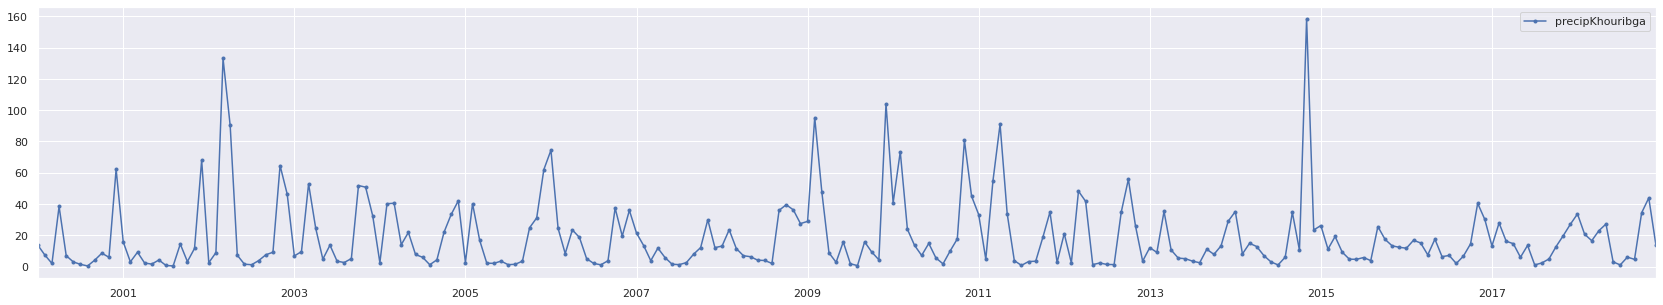

In [17]:
df_kh.plot(marker='.', figsize=(29,5));

#### Stationarity test

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_kh)

if pvalue < 0.05:
    print(f"Data stationary, pvalue = {pvalue}")
else:
    print(f"Data NOT stationary, pvalue = {pvalue}")

Data stationary, pvalue = 0.004325484203942917


Creating columns containing year and month to see if there is any trends with respect to years and months.

In [20]:
df_kh['year'] = [d.year for d in df_kh.index]
df_kh['month'] = [d.strftime('%b') for d in df_kh.index]
df_kh.head()

,precipKhouribga,year,month
2000-01-01,13.872842,2000,Jan
2000-02-01,7.474373,2000,Feb
2000-03-01,2.075285,2000,Mar
2000-04-01,38.477597,2000,Apr
2000-05-01,7.025321,2000,May


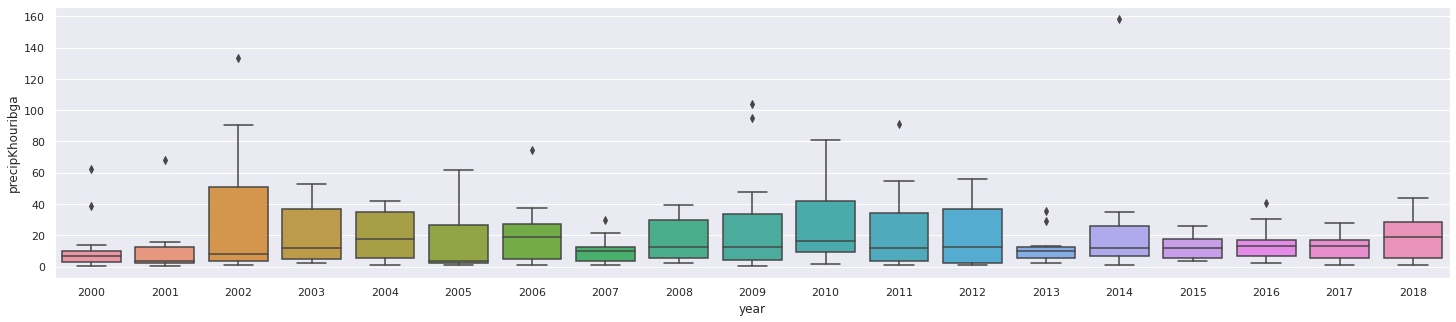

In [21]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(x='year', y="precipKhouribga", data=df_kh, ax=ax);

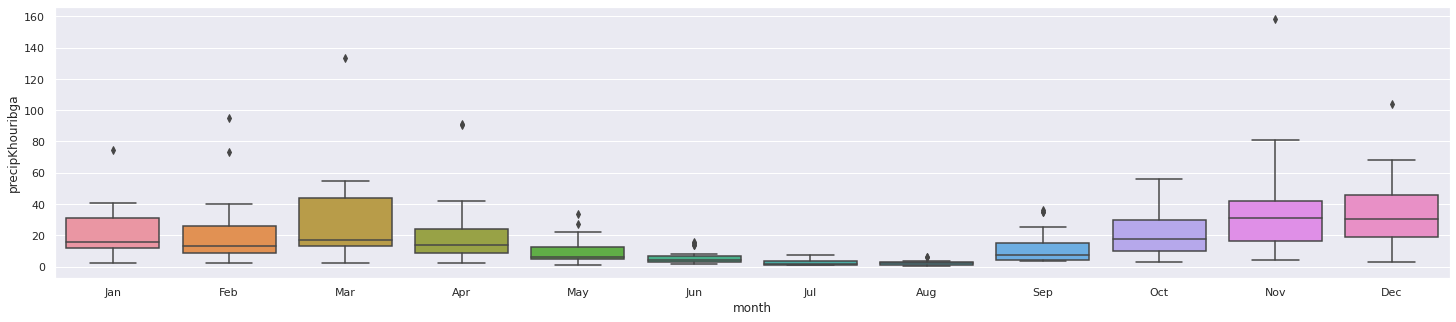

In [22]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(x='month', y="precipKhouribga", data=df_kh, ax=ax);

#### Extract and plot trend, seasonal and residuals

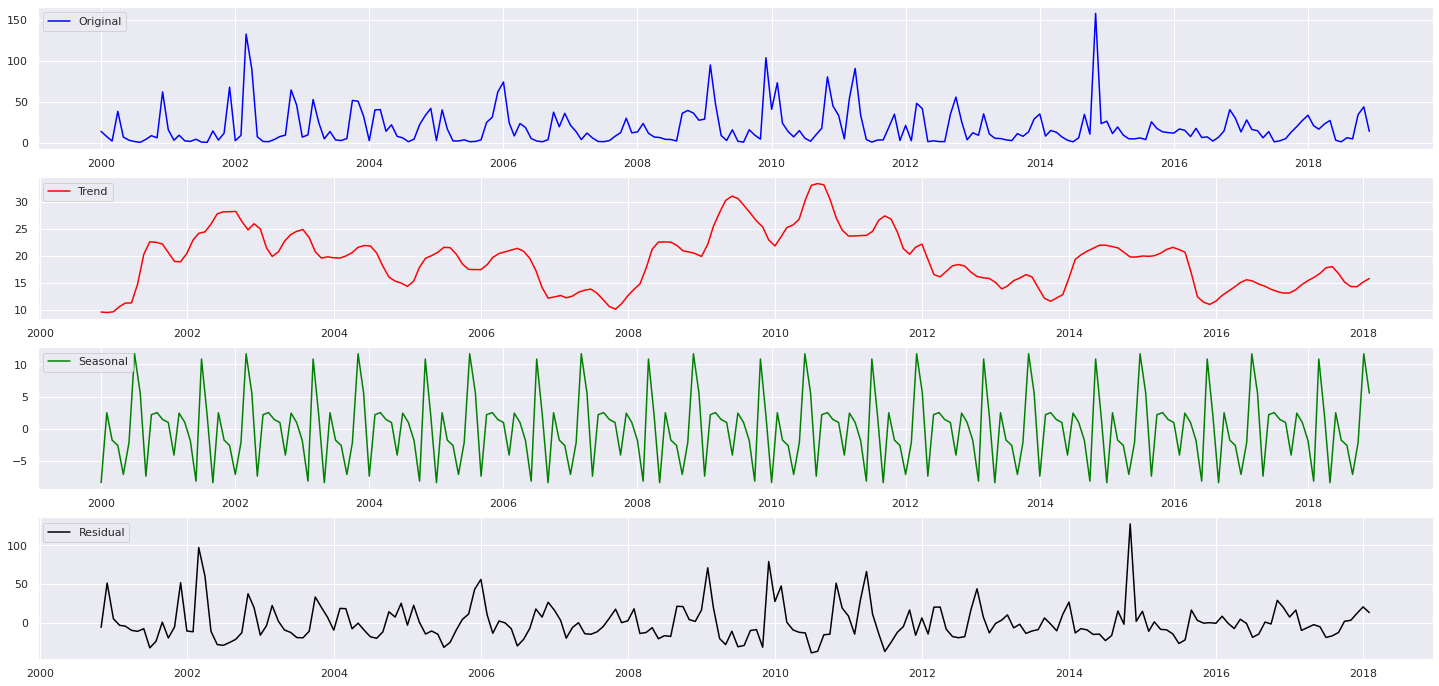

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df_kh['precipKhouribga'], model ='additive', period=20)

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

plt.figure(figsize=(25,12))
plt.subplot(411)
plt.plot(df_kh['precipKhouribga'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')
plt.show()

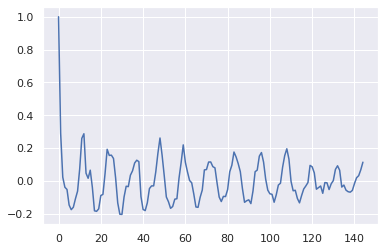

In [24]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

from statsmodels.tsa.stattools import acf

acf_144 = acf(df_kh['precipKhouribga'], nlags=144)
plt.plot(acf_144);

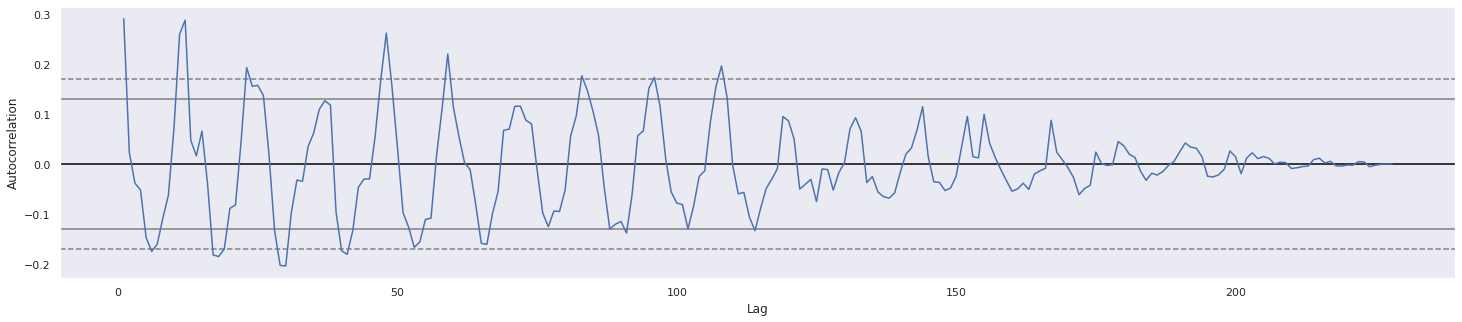

In [25]:
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize=(25, 5))
autocorrelation_plot(df_kh['precipKhouribga'],ax=ax);

## Forecasting using LSTM

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [27]:
df_kh.head()

,precipKhouribga,year,month
2000-01-01,13.872842,2000,Jan
2000-02-01,7.474373,2000,Feb
2000-03-01,2.075285,2000,Mar
2000-04-01,38.477597,2000,Apr
2000-05-01,7.025321,2000,May


In [28]:
# load the dataset
dataframe = df_kh['precipKhouribga']

In [29]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('int32') #COnvert values to float

# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset.reshape(-1,1))

#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

We cannot fit the model like we normally do for image processing where we have
X and Y. We need to transform our data into something that looks like X and Y values.
This way it can be trained on a sequence rather than indvidual datapoints. 
Let us convert into n number of columns for X where we feed sequence of numbers
then the final column as Y where we provide the next number in the sequence as output.
So let us convert an array of values into a dataset matrix


In [30]:
#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

# def to_sequences(dataset, seq_size=1):
#     x = []
#     y = []

#     for i in range(len(dataset)-seq_size-1):
#         #print(i)
#         window = dataset[i:(i+seq_size), 0]
#         x.append(window)
#         y.append(dataset[i+seq_size, 0])
        
#     return np.array(x),np.array(y)
    

seq_size = 12 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
# trainX, trainY = to_sequences(train, seq_size)
# testX, testY = to_sequences(test, seq_size)

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

# print("Shape of training set: {}".format(trainX.shape))
# print("Shape of test set: {}".format(testX.shape))

#Use TimeseriesGenerator to organize training data into the right format
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
batch_size = 1
train_generator = TimeseriesGenerator(train.reshape(-1), train.reshape(-1), length=seq_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) # 95
print("Total number of samples in the generated data = ", len(train_generator)) # 55
#With length 40 it generated 55 samples, each of length 40 (by using data of length 95)

# print a couple of samples... 
#x, y = train_generator[0]

#Also generate validation data
validation_generator = TimeseriesGenerator(test.reshape(-1), test.reshape(-1), length=seq_size, batch_size=batch_size)

Total number of samples in the original training data =  182
Total number of samples in the generated data =  170


In [31]:
################################################
#Input dimensions are... (N x seq_size)
print('Build feed forward NN model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

######################################################
model.fit_generator(generator=train_generator, verbose=2, epochs=100, validation_data=validation_generator)

Build feed forward NN model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________
None


2022-02-27 19:02:01.968869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_112819/4228019416.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator, verbose=2, epochs=100, validation_data=validation_generator)


Epoch 1/100
170/170 - 1s - loss: 0.0269 - acc: 0.0235 - val_loss: 0.0038 - val_acc: 0.0000e+00 - 545ms/epoch - 3ms/step
Epoch 2/100
170/170 - 0s - loss: 0.0222 - acc: 0.0235 - val_loss: 0.0038 - val_acc: 0.0000e+00 - 171ms/epoch - 1ms/step
Epoch 3/100
170/170 - 0s - loss: 0.0207 - acc: 0.0235 - val_loss: 0.0039 - val_acc: 0.0000e+00 - 153ms/epoch - 902us/step
Epoch 4/100
170/170 - 0s - loss: 0.0192 - acc: 0.0235 - val_loss: 0.0045 - val_acc: 0.0000e+00 - 154ms/epoch - 904us/step
Epoch 5/100
170/170 - 0s - loss: 0.0187 - acc: 0.0235 - val_loss: 0.0043 - val_acc: 0.0000e+00 - 166ms/epoch - 978us/step
Epoch 6/100
170/170 - 0s - loss: 0.0181 - acc: 0.0235 - val_loss: 0.0037 - val_acc: 0.0000e+00 - 158ms/epoch - 931us/step
Epoch 7/100
170/170 - 0s - loss: 0.0174 - acc: 0.0235 - val_loss: 0.0038 - val_acc: 0.0000e+00 - 149ms/epoch - 876us/step
Epoch 8/100
170/170 - 0s - loss: 0.0169 - acc: 0.0235 - val_loss: 0.0044 - val_acc: 0.0000e+00 - 146ms/epoch - 859us/step
Epoch 9/100
170/170 - 0s - l

In [32]:
model.save("modelLSTMv00.h5")

In [36]:
# make predictions

trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)

# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[seq_size:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[seq_size:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.62 RMSE
Test Score: 9.67 RMSE


In [37]:
testY_inverse.shape

(46, 1)

In [38]:
df_kh['precipKhouribga'][-12:]

2018-01-01    33.698877
2018-02-01    20.748062
2018-03-01    16.613244
2018-04-01    23.001947
2018-05-01    27.257460
2018-06-01     3.066180
2018-07-01     1.136341
2018-08-01     6.111350
2018-09-01     4.688000
2018-10-01    34.422764
2018-11-01    43.916373
2018-12-01    13.955878
Name: precipKhouribga, dtype: float64

In [39]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(train)+(seq_size)-1:len(dataset)-1, :] = testPredict

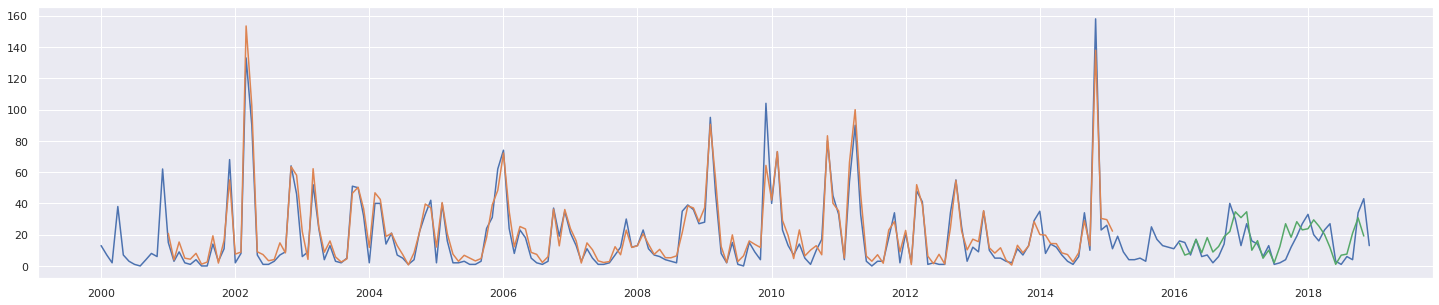

In [40]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(df_kh.index, scaler.inverse_transform(dataset))
plt.plot(df_kh.index, trainPredictPlot)
plt.plot(df_kh.index, testPredictPlot)
plt.show()

In [41]:
df_kh.head()

,precipKhouribga,year,month
2000-01-01,13.872842,2000,Jan
2000-02-01,7.474373,2000,Feb
2000-03-01,2.075285,2000,Mar
2000-04-01,38.477597,2000,Apr
2000-05-01,7.025321,2000,May


In [42]:
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541
2000-01-01,5.139662,5.185174,12.736306,7.222152,8.277916,10.003084,3.690965,4.015777,3.724388,3.973375,...,80.943738,53.279457,58.557885,42.157584,37.573582,37.573582,37.573582,37.573582,39.338377,40.711483
2000-02-01,2.320398,2.510182,7.483267,3.029178,3.857246,4.342615,2.725529,1.264757,2.803877,1.386363,...,1.866421,1.128736,1.365121,0.964586,0.890602,0.890602,0.890602,0.890602,0.922023,1.099783
2000-03-01,1.026504,0.911228,4.644095,0.968059,2.144454,1.894135,1.811047,1.650475,1.805033,0.908379,...,28.641492,19.283579,24.587897,5.983350,6.307444,6.307444,6.307444,6.307444,6.350355,3.502182
2000-04-01,0.994122,0.929610,3.478880,0.909780,1.619741,1.273522,1.302462,0.677425,1.902222,0.860408,...,95.467146,113.049248,108.450883,72.007683,69.569077,69.569077,69.569077,69.569077,70.999270,56.441982
2000-05-01,0.000000,0.000000,0.749234,0.000000,0.010291,0.000000,0.000000,0.974401,0.000000,0.984279,...,46.760845,48.911781,53.525117,21.432269,22.532732,22.532732,22.532732,22.532732,21.880218,18.199196


In [43]:
pd.DataFrame(df_kh['precipKhouribga']).to_json('precipKh.json', date_unit='ns')